In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [2]:
class Material:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Hkeff=6100.0, t=5e-9):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Hkeff = Hkeff
        self.t = t

        
class LayeredFilm:
    def __init__(self, layer1, layer2, J):
        self.l1 = layer1
        self.l2 = layer2
        self.J = J

        
def StonerWohlfarth_Heff(M, Hkeff):
    Mx, My, Mz = M
    x = -0.5*Hkeff*Mx*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
    y = -0.5*Hkeff*My*Mz**2/(Mx**2 + My**2 + Mz**2)**(3/2)
    z = Hkeff*Mz*(1.0*Mx**2 + 1.0*My**2 + 0.5*Mz**2)/(Mx**2 + My**2 + Mz**2)**(3/2)
    
    return np.array([x, y, z])


def IEC_Heff1(M1, M2, J, mu0, t1):
    M1_abs, M1_tet, M1_phi = cart2pol(M1)
    M2_abs, M2_tet, M2_phi = cart2pol(M2)
    
    K = J/(mu0*t1)
    return -K*(M2/M2_abs)*(2.0/M1_abs)

def IEC_Heff2(M1, M2, J, mu0, t2):
    return IEC_Heff1(M2, M1, J, mu0, t2)

In [3]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class LLG_EQ:
    def __init__(self):
        S = CoordSys3D('S')
        
        x, y, z = symbols('x y z')
        dMdt = x*S.i + y*S.j + z*S.k
        
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        Hx, Hy, Hz = symbols('Hx Hy Hz')
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        g = sym.Symbol('g')
        a = sym.Symbol('a')
        Ms = sym.Symbol('Ms')
        
        vec_eq = -dMdt - g*M.cross(H)+(a/Ms)*(M.cross(dMdt))
        sol = sym.solve(vec_eq.to_matrix(S), dMdt.to_matrix(S))
        
        sol[x] = simplify(sol[x])
        sol[y] = simplify(sol[y])
        sol[z] = simplify(sol[z])
        
        self.sol_lamb = dict()
        lambda_var_set = (
            a, g, Ms, 
            Mx, My, Mz, 
            Hx, Hy, Hz)
        
        self.sol_lamb['x'] = lambdify(lambda_var_set, sol[x], 'numpy')
        self.sol_lamb['y'] = lambdify(lambda_var_set, sol[y], 'numpy')
        self.sol_lamb['z'] = lambdify(lambda_var_set, sol[z], 'numpy')
        
        symbs = [x, y, z]
        dsymbs = [Mx, My, Mz]
        self.jac_mat = []
        for i in range(3):
            jac_row = []
            for j in range(3):
                jac_row.append(
                    lambdify(
                        lambda_var_set, 
                        simplify(sol[symbs[i]].diff(dsymbs[j]))
                    )
                )
            self.jac_mat.append(jac_row)
    
    def right_hand(self, Heff, M, layer):
        x = self.sol_lamb['x'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        y = self.sol_lamb['y'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        z = self.sol_lamb['z'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        return [x, y, z]
    
    #not allowed for multilayer no
    def jacobian(self, M, Heff, film):
        ret = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                ret[i][j] = self.jac_mat[i][j](
                    film.alpha, film.gamma, np.linalg.norm(M),
                    M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
                )
        return ret
             
    


In [126]:
mu0 = 1.2566370621219e-6
layer1 = Material(1042e3, gamma=1.76e11*mu0, alpha=0.010)
layer2 = Material(1042e3, gamma=1.76e11*mu0, alpha=0.010)
film_inst = LayeredFilm(layer1, layer2, 2.7e-3)
equation = LLG_EQ()

#Hext = np.array(pol2cart(110e-3/mu0, np.deg2rad(0.0), 0.0))
Hext = np.array([110e-3/mu0,0.0,0.0])


def Heff_function(M1, M2, film):
    Heff1 = Hext + StonerWohlfarth_Heff(M1, film.l1.Hkeff) + IEC_Heff1(M1, M2, film.J, mu0, film.l1.t)
    Heff2 = Hext + StonerWohlfarth_Heff(M2, film.l2.Hkeff) + IEC_Heff2(M1, M2, film.J, mu0, film.l2.t)
    return Heff1, Heff2


def model(t,M1_M2):
    M1 = M1_M2[0:3]
    M2 = M1_M2[3:6]
    
    Heff1, Heff2 = Heff_function(M1, M2, film_inst)
    
    LLG1 = equation.right_hand(Heff1, M1, film_inst.l1)
    LLG2 = equation.right_hand(Heff2, M2, film_inst.l2)
    
    return np.append(LLG1, LLG2)


M01 = pol2cart(film_inst.l1.Ms, np.deg2rad(90.0), np.deg2rad(0.0))
M02 = pol2cart(film_inst.l2.Ms, np.deg2rad(90.0), np.deg2rad(170.0))
M01_M02 = np.append(M01, M02)


time_span = [0.0, 1000.0e-12]
sol = solve_ivp(model, time_span, M01_M02,t_eval=np.linspace(time_span[0], time_span[1],100000),
                method = 'RK45', max_step=1e-13)


df = pd.DataFrame()
df['t'] = sol.t

df['x1'] = sol.y[0]
df['y1'] = sol.y[1]
df['z1'] = sol.y[2]
df['r1'] = np.sqrt(df['x1']**2+df['y1']**2+df['z1']**2)

df['x2'] = sol.y[3]
df['y2'] = sol.y[4]
df['z2'] = sol.y[5]
df['r2'] = np.sqrt(df['x2']**2+df['y2']**2+df['z2']**2)
df

,t,x1,y1,z1,r1,x2,y2,z2,r2
0,0.000000e+00,1.042000e+06,0.000000,6.380410e-11,1042000.0,-1.026170e+06,180941.401129,6.380410e-11,1042000.0
1,1.000010e-14,1.042000e+06,-3.357438,3.300342e+02,1042000.0,-1.026170e+06,180938.553749,-2.950090e+02,1042000.0
2,2.000020e-14,1.042000e+06,-6.828931,6.600554e+02,1042000.0,-1.026170e+06,180935.822238,-5.900085e+02,1042000.0
3,3.000030e-14,1.042000e+06,-10.414472,9.900635e+02,1042000.0,-1.026171e+06,180933.206589,-8.849987e+02,1042000.0
4,4.000040e-14,1.041999e+06,-14.114051,1.320058e+03,1042000.0,-1.026171e+06,180930.706794,-1.179979e+03,1042000.0
...,...,...,...,...,...,...,...,...,...
99995,9.999600e-10,-1.274816e+05,-101919.074031,1.029138e+06,1042000.0,2.474477e+05,89064.293092,-1.008266e+06,1042000.0
99996,9.999700e-10,-1.274610e+05,-101899.006165,1.029143e+06,1042000.0,2.474291e+05,89035.661410,-1.008274e+06,1042000.0
99997,9.999800e-10,-1.274404e+05,-101878.935450,1.029147e+06,1042000.0,2.474106e+05,89007.028195,-1.008281e+06,1042000.0
99998,9.999900e-10,-1.274197e+05,-101858.861886,1.029152e+06,1042000.0,2.473920e+05,88978.393449,-1.008288e+06,1042000.0


<IPython.core.display.Javascript object>


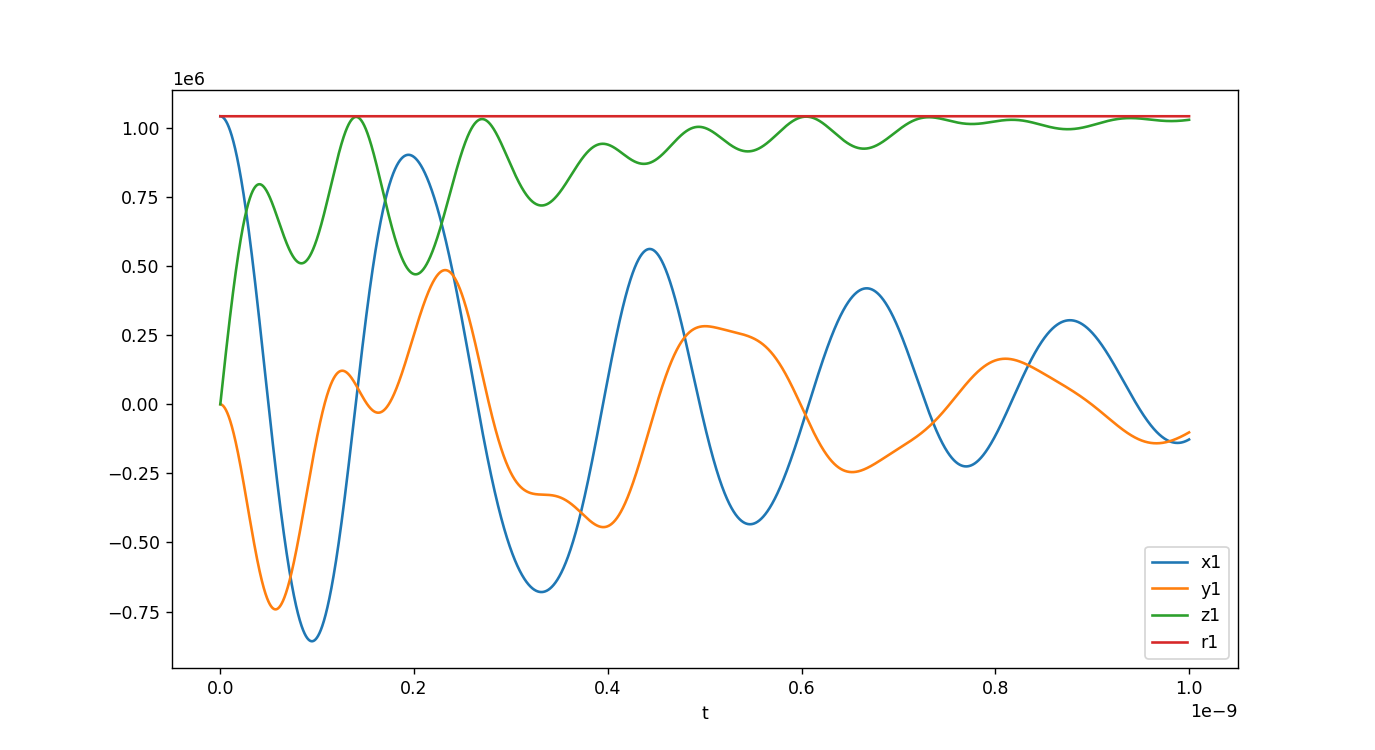

<AxesSubplot:xlabel='t'>

In [127]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x1', 'y1', 'z1', 'r1'], figsize = (11, 6))

<IPython.core.display.Javascript object>


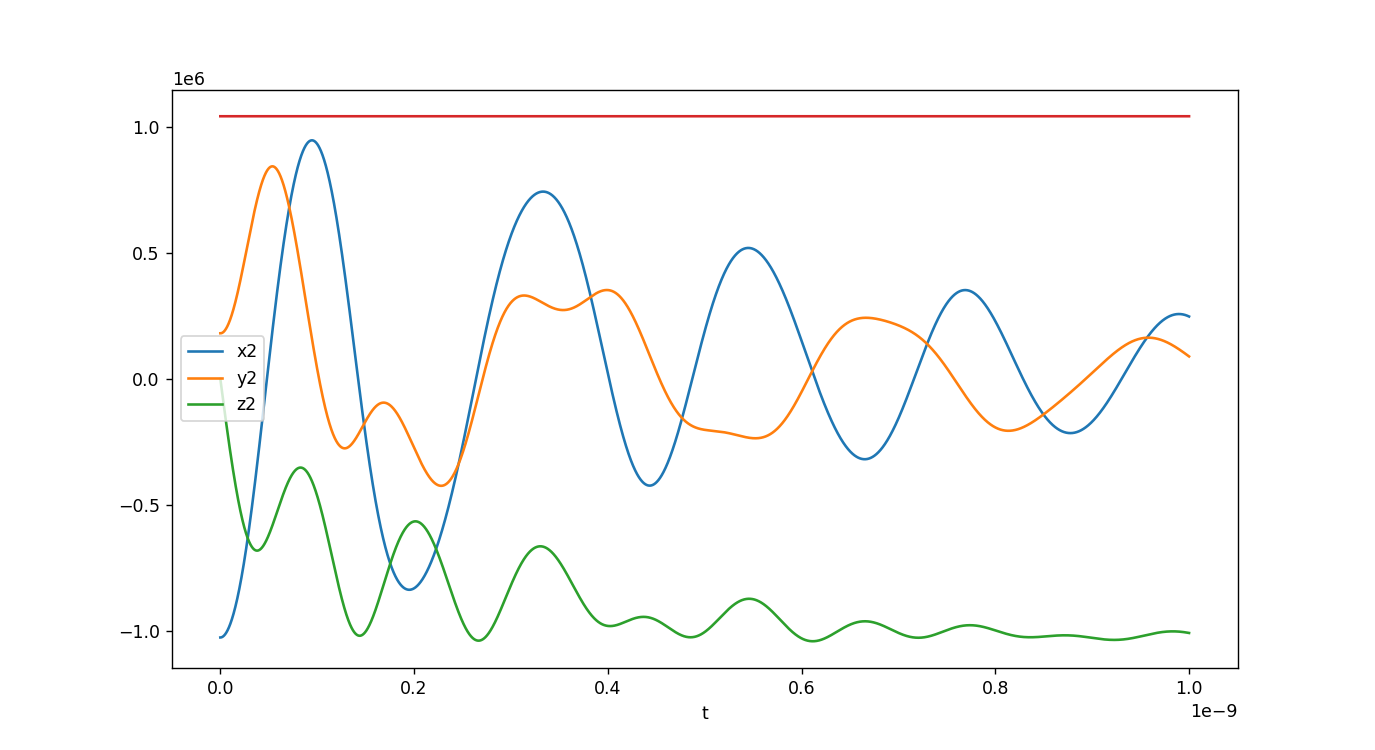

In [128]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x2', 'y2', 'z2'], figsize = (11, 6))
plt.plot(sol.t, np.sqrt(sol.y[3]**2 + sol.y[4]**2 + sol.y[5]**2))

<IPython.core.display.Javascript object>


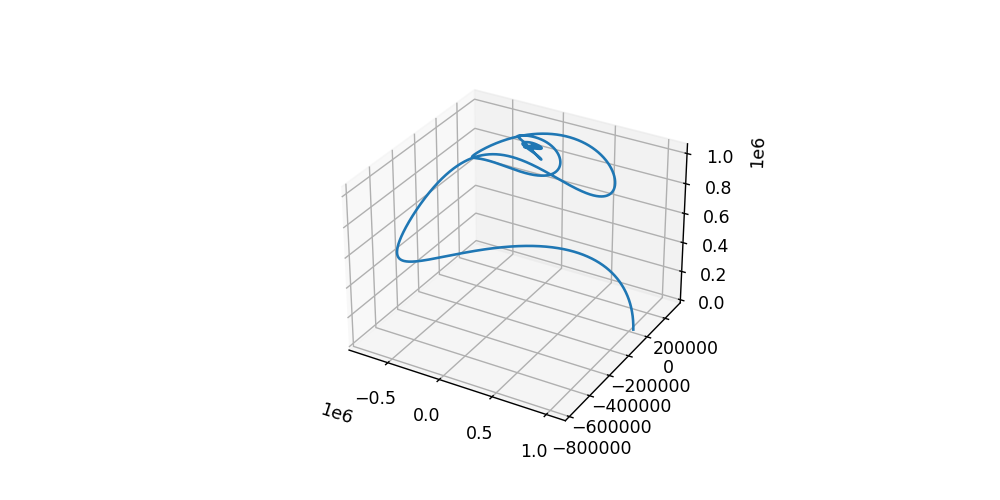

In [120]:
#%matplotlib inline
%matplotlib notebook
#%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

#heff = [];
#for i in range(len(sol.t)):
#    heff.append(Heff(Hext, sol.y.T[i]))

#heff = np.array(heff).T

#ax.plot(heff[0], heff[1], heff[2])

<IPython.core.display.Javascript object>


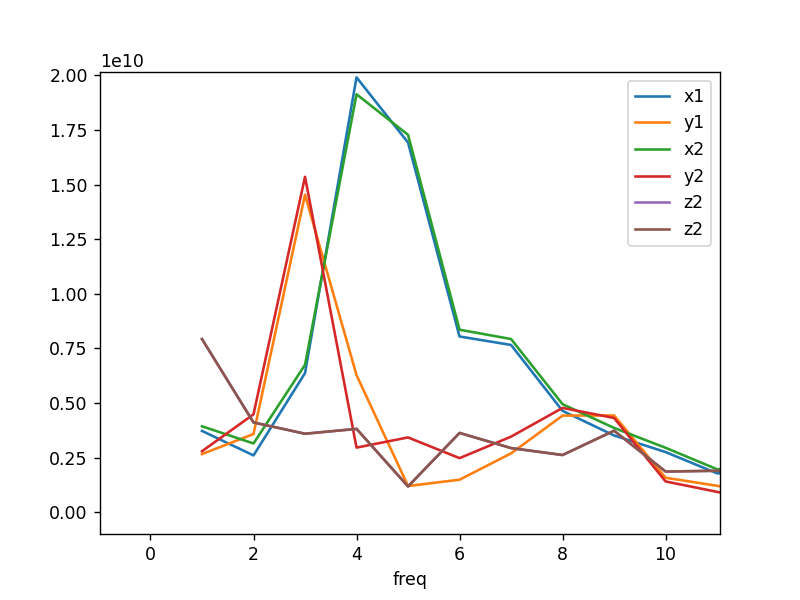

<AxesSubplot:xlabel='freq'>

In [131]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x1','y1','z1','x2','y2','z2'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:10000] * 1e-9

column_names = ['x1','y1','z1','x2','y2','z2']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:10000]

freq_df.plot(x='freq', y=['x1','y1', 'x2', 'y2', 'z2', 'z2'])


<IPython.core.display.Javascript object>


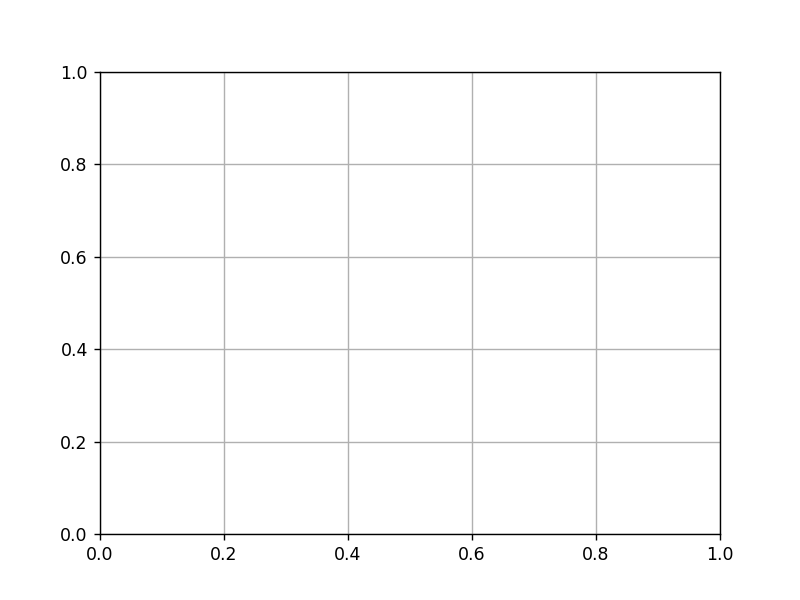

NameError: name 'heff' is not defined

In [101]:

%matplotlib notebook
plt.grid(True)
plt.plot(sol.t, heff[0])
plt.plot(sol.t, heff[1])
plt.plot(sol.t, heff[2])

In [133]:
Heff(Hext, M0)

array([-3928.13389116,    -0.        ,  1790.43286243])

In [100]:
Hext

array([1969.61550602,    0.        ,  347.29635533])

In [101]:
M0

array([100.,   0., 150.])

<IPython.core.display.Javascript object>


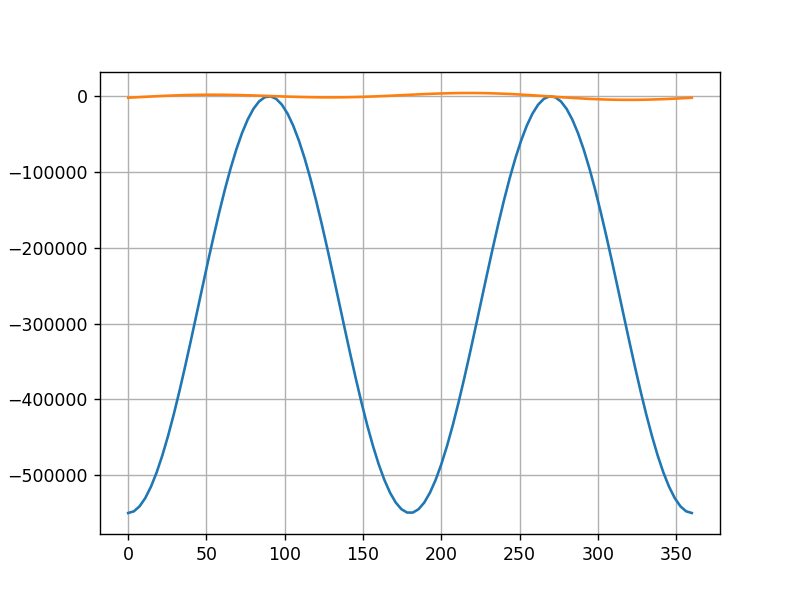

In [137]:
%matplotlib notebook
def F(Hext, M, tet):
    H_abs, H_tet, H_phi = cart2pol(Hext)
    M_abs, M_tet, M_phi = cart2pol(M)
    return -M_abs*H_abs*np.cos(H_tet - tet) - 0.5*M_abs*Hkeff*(np.cos(tet)**2)
    
def dF(Hext, M, tet):
    H_abs, H_tet, H_phi = cart2pol(Hext)
    M_abs, M_tet, M_phi = cart2pol(M)
    return 0.5*Hkeff*np.sin(2*tet) - H_abs*np.sin(H_tet - tet)
    
x = np.linspace(0,2*np.pi, 100)
y = []
y2 = []
for i in range(len(x)):
    y.append(F(Hext, M0, x[i]))
    y2.append(dF(Hext, M0, x[i]))

y = np.array(y)
plt.plot(np.rad2deg(x), y)
plt.plot(np.rad2deg(x), y2)
plt.grid()

In [149]:
Heff(Hext, M0)

array([1969.61550602,    0.        ,  347.29635533])

In [7]:
a = np.array([1,3])
b = np.array([2,3])
np.append(a, b)

array([1, 3, 2, 3])